In [146]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels as sm
import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from statsmodels.stats.anova import anova_lm

In [147]:
dia = pd.read_csv("C:/Users/Iris/OneDrive/Desktop/Data/datasets/dia2.csv")
dia

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [148]:
# Upon checking, there seems to be some repeated diamonds. We clean up this dataset below (note, originally, there are over 50,000 entries)

In [149]:
check = ["carat", "cut", "color", "clarity", "price"]
dia_unique = dia.drop_duplicates(subset = check)
dia_unique = dia_unique.copy()

print(f"Unique diamonds: {len(dia_unique)}")

Unique diamonds: 39756


In [150]:
# First here, we'll test the basic linear correlation and importance of that correlation (p-value) 
# between carat and price. We should see a pretty strong correlation, closer to 1.0 than not, and a p-value closest to 0 as possible.

In [151]:
r, p = spearmanr(dia_unique["carat"], dia_unique["price"])
print("Spearman correlation:", r)
print("p-value:", p)

Spearman correlation: 0.9583444437459829
p-value: 0.0


In [152]:
# Now that we know that there is a strong correlation between the two, our first goal will be to predict price based on not only carat, but also cut.

# Goal 1: Create an equation for price prediction based on cut and carat.

In [186]:
cut_model = smf.ols("price ~ carat + C(cut)", data = dia_unique).fit()

with open("cut_model_summary.txt", "w") as f:
    f.write(cut_model.summary().as_text())

print(cut_model.summary2().tables[0])
print(cut_model.summary2().tables[1].head(10))

# Prediction of price equation:
# Where the input is 1 for the cut rating and 0 for all others, and 0 for all if the cut grading is fair. 

# Price = -4,065.27 + 8,078.18 * carat + 1,779.47 * (Ideal) + 1,317.57 * (Premium) + 1,478.95 * (Very Good) + 1,087.57 * (Good)

                     0                 1                    2            3
0               Model:               OLS      Adj. R-squared:        0.838
1  Dependent Variable:             price                 AIC:  703931.8606
2                Date:  2025-10-20 11:58                 BIC:  703983.4037
3    No. Observations:             39756      Log-Likelihood:  -3.5196e+05
4            Df Model:                 5         F-statistic:    4.103e+04
5        Df Residuals:             39750  Prob (F-statistic):         0.00
6           R-squared:             0.838               Scale:   2.8656e+06
                           Coef.   Std.Err.           t          P>|t|  \
Intercept           -4065.266486  47.701347  -85.223307   0.000000e+00   
C(cut)[T.Good]       1087.570713  51.123667   21.273331  7.241296e-100   
C(cut)[T.Ideal]      1779.471577  46.151549   38.557137   0.000000e+00   
C(cut)[T.Premium]    1317.569460  47.074001   27.989324  9.990990e-171   
C(cut)[T.Very Good]  1478.9483

In [154]:
# Goal 2: Plot carat against price, and color code the plot points by the cut of the diamond.

In [155]:
cut_codes = dia_unique['cut'].astype('category').cat.codes
cut_labels = dia_unique['cut'].astype('category').cat.categories

Text(0.5, 1.0, 'Average Diamond Price by Carat and Cut')

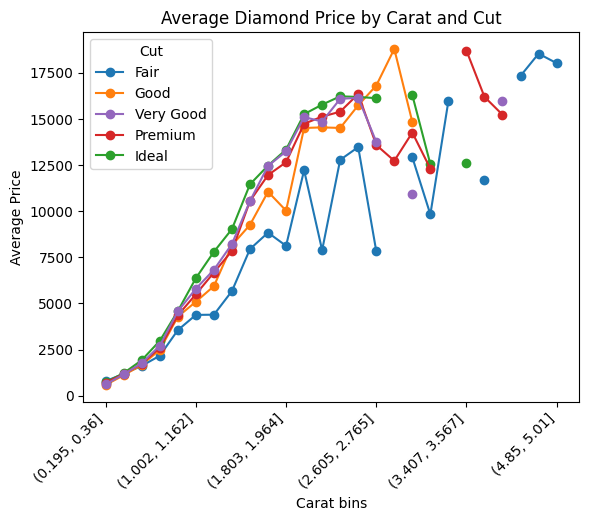

In [156]:
binned = dia_unique.groupby([pd.cut(dia_unique["carat"], 30), "cut"], observed=True)["price"].mean().unstack()
binned.plot(kind="line", marker="o")

handles, labels = plt.gca().get_legend_handles_labels()
order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]

handles = [handles[labels.index(cat)] for cat in order]
labels = order

plt.legend(handles, labels, title="Cut")

plt.ylabel("Average Price")
plt.xlabel("Carat bins")
plt.xticks(rotation=45, ha="right")
plt.title("Average Diamond Price by Carat and Cut")

In [157]:
# Above, we can see that as we compare carat weight to average price while filtering for the cut of the diamond, we see our linear pattern,
# showing us that cut and carat are okay predictors for price of a diamond, but still somewhat erratic. 
# Below, we'll investigate other, possibly clearer predictors for the price of a diamond based on carat weight. 

In [158]:
# We've seen how cut and carat combined can be okay predictors, our next goal will be to predict price based on carat and clarity.

# Goal 3: Create an equation for price prediction based on carat and clarity.

In [185]:
clarity_model = smf.ols("price ~ carat + C(clarity)", data = dia_unique).fit()

with open("clarity_model_summary.txt", "w") as f:
    f.write(clarity_model.summary().as_text())

print(clarity_model.summary2().tables[0])
print(clarity_model.summary2().tables[1].head(10))

# Prediction of price equation:
# Where the input is 1 for the clarity rating and 0 for all others, and 0 for all if the clarity grading is I1. 

# Price = -7,265.52 + 8,687.36 * (carat) + 5,932.81 * (IF) + 5,490.28 * (VVS1) + 5,433.79 * (VVS2) + 4,736.79 * (VS1) + 4,404.53 * (VS2) + 3,719.05 * (SI1) + 2,887.87 * (SI2)

                     0                 1                    2            3
0               Model:               OLS      Adj. R-squared:        0.885
1  Dependent Variable:             price                 AIC:  690339.3942
2                Date:  2025-10-20 11:58                 BIC:  690416.7089
3    No. Observations:             39756      Log-Likelihood:  -3.4516e+05
4            Df Model:                 8         F-statistic:    3.813e+04
5        Df Residuals:             39747  Prob (F-statistic):         0.00
6           R-squared:             0.885               Scale:   2.0356e+06
                          Coef.   Std.Err.           t  P>|t|       [0.025  \
Intercept          -7265.515485  57.472157 -126.418006    0.0 -7378.162273   
C(clarity)[T.IF]    5932.808273  69.068399   85.897579    0.0  5797.432575   
C(clarity)[T.SI1]   3719.054211  55.839016   66.603147    0.0  3609.608417   
C(clarity)[T.SI2]   2887.869492  56.069967   51.504747    0.0  2777.971029   
C(clarity)

In [160]:
# Goal 4: Plot carat against price, and color code the plot points by the clarity of the diamond.

In [161]:
clarity_codes = dia_unique['clarity'].astype('category').cat.codes
clarity_labels = dia_unique['clarity'].astype('category').cat.categories

Text(0.5, 1.0, 'Average Diamond Price by Carat and Clarity')

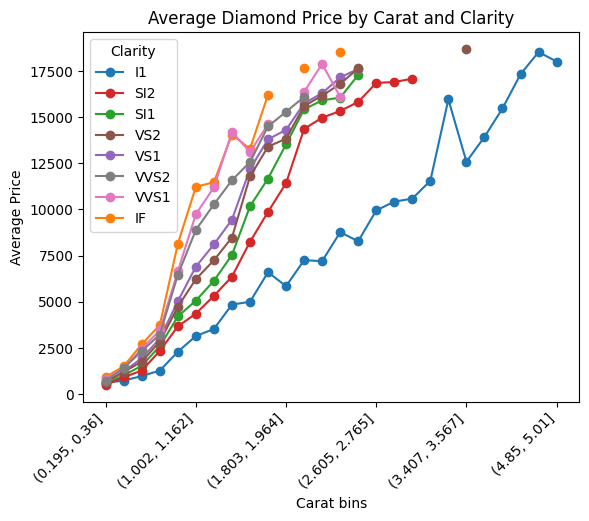

In [162]:
binned = dia_unique.groupby([pd.cut(dia_unique["carat"], 30), "clarity"], observed=True)["price"].mean().unstack()
binned.plot(kind="line", marker="o")

handles, labels = plt.gca().get_legend_handles_labels()
order = ["I1","SI2", "SI1","VS2","VS1","VVS2","VVS1","IF"]

handles = [handles[labels.index(cat)] for cat in order]
labels = order

plt.legend(handles, labels, title="Clarity")

plt.ylabel("Average Price")
plt.xlabel("Carat bins")
plt.xticks(rotation=45, ha="right")
plt.title("Average Diamond Price by Carat and Clarity")

In [163]:
# In the above graph, we can clearly see a stronger, more consistent linear pattern, indicating that the combination of carat size and clarity grading provides a more consistent 
# set of predictors than cut and clarity alone.  

# You can see, quite neatly, that as clarity goes down, prices drop on average, and that for each clarity grade
# as carat weight goes up, the price maintains a consistent increase as well. 
# Finally, we observe that as the quality of the diamond gets better, the increase in price by carat becomes steeper, indicating that clarity is a significant factor in price.

In [164]:
# We've now seen cut and clarity show good potential as single predictors, so our next goal will be to predict price based on carat and color.

# Goal 5: Create an equation for price prediction based on carat and color.

In [187]:
color_model = smf.ols("price ~ carat + C(color)", data = dia_unique).fit()

with open("color_model_summary.txt", "w") as f:
    f.write(color_model.summary().as_text())

print(color_model.summary2().tables[0])
print(color_model.summary2().tables[1].head(10))

# Prediction of price equation:
# Where the input is 1 for the color rating and 0 for all others, or 0 for all if the color grade is D

# Price = -2,342.57 + 8,340.03 * (carat) - 135.42 * (E) - 94.37 * (F) - 167.48 * (G) - 929.26 * (H) -1,259.03 * (I) - 2,117.86 * (J)

                     0                 1                    2            3
0               Model:               OLS      Adj. R-squared:        0.849
1  Dependent Variable:             price                 AIC:  700992.1296
2                Date:  2025-10-20 11:59                 BIC:  701060.8538
3    No. Observations:             39756      Log-Likelihood:  -3.5049e+05
4            Df Model:                 7         F-statistic:    3.200e+04
5        Df Residuals:             39748  Prob (F-statistic):         0.00
6           R-squared:             0.849               Scale:   2.6612e+06
                     Coef.   Std.Err.           t          P>|t|       [0.025  \
Intercept     -2342.568167  27.402210  -85.488295   0.000000e+00 -2396.277146   
C(color)[T.E]  -135.419385  31.134152   -4.349545   1.367597e-05  -196.443059   
C(color)[T.F]   -94.369774  30.867723   -3.057231   2.235400e-03  -154.871242   
C(color)[T.G]  -167.481387  30.303799   -5.526746   3.282689e-08  -226.87755

In [166]:
# Goal 6: Plot carat against price, and color code the plot points by the color of the diamond.

Text(0.5, 1.0, 'Average Diamond Price by Carat and Color')

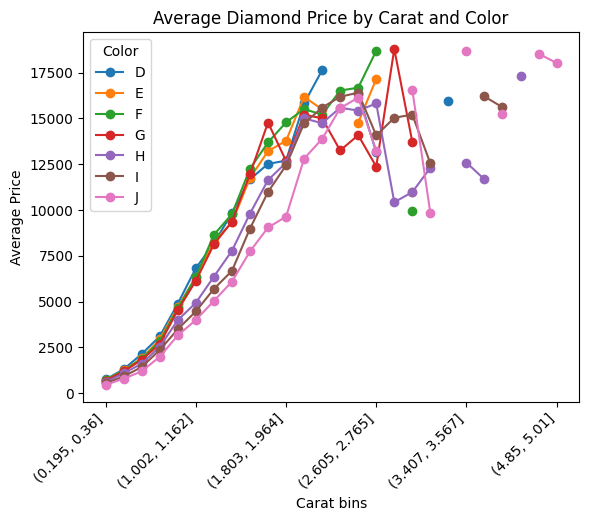

In [167]:
color_codes = dia_unique['color'].astype('category').cat.codes
color_labels = dia_unique['color'].astype('category').cat.categories

binned = dia_unique.groupby([pd.cut(dia_unique["carat"], 30), "color"], observed=True)["price"].mean().unstack()
binned.plot(kind="line", marker="o")

handles, labels = plt.gca().get_legend_handles_labels()
order = ["D","E", "F", "G", "H", "I", "J"]

handles = [handles[labels.index(cat)] for cat in order]
labels = order

plt.legend(handles, labels, title="Color")

plt.ylabel("Average Price")
plt.xlabel("Carat bins")
plt.xticks(rotation=45, ha="right")
plt.title("Average Diamond Price by Carat and Color")

In [168]:
# Seeing again a linear pattern, but finding a more erratic behaviour, we will head into a combined, full prediction model with multiple predictors. 

In [169]:
# Goal 7: Our final analysis and visualisation goal is to build the fullest, most accurate predictive model for price, including interactions. 

In [188]:
full_model = smf.ols("price ~ carat * C(clarity) * C(cut) * C(color)", data = dia_unique).fit()

with open("full_model_summary.txt", "w") as f:
    f.write(full_model.summary().as_text())

print(full_model.summary2().tables[0])
print(full_model.summary2().tables[1].head(10))

                     0                 1                    2            3
0               Model:               OLS      Adj. R-squared:        0.941
1  Dependent Variable:             price                 AIC:  663923.7863
2                Date:  2025-10-20 11:59                 BIC:  668622.7986
3    No. Observations:             39756      Log-Likelihood:  -3.3141e+05
4            Df Model:               546         F-statistic:        1172.
5        Df Residuals:             39209  Prob (F-statistic):         0.00
6           R-squared:             0.942               Scale:   1.0335e+06
                          Coef.     Std.Err.         t     P>|t|       [0.025  \
Intercept          -2933.702508  1149.368594 -2.552447  0.010701 -5186.493099   
C(clarity)[T.IF]    2264.259586  3447.736901  0.656738  0.511353 -4493.389174   
C(clarity)[T.SI1]  -1376.395311  1226.128092 -1.122554  0.261634 -3779.636399   
C(clarity)[T.SI2]  -1140.258381  1224.347429 -0.931319  0.351694 -3540.00932

In [171]:
X = pd.get_dummies(dia_unique[["carat", "cut", "clarity", "color"]], drop_first = True)
y = dia_unique["price"]

mod = LinearRegression()

scores = cross_val_score(mod, X, y, cv=KFold(5, shuffle = True, random_state = 42), scoring = 'r2')
print("Cross validated R sq.:", np.mean(scores))

Cross validated R sq.: 0.9105206831667741


In [172]:
# So far, our AIC and BIC have gone down, the adjusted R squared value is increasing, and our cross validated R squared is very close to said adjusted R squared,
# meaning our model is increasing in effectiveness, without overfitting. 

# Upon creating a residuals plot though, it seems as though our model has some issues with consistent variance, so we'll log transform price and carat below.

In [189]:
dia_unique["log_price"] = np.log(dia_unique["price"])
dia_unique["log_carat"] = np.log(dia_unique["carat"])

loglog_mod = smf.ols("log_price ~ log_carat * C(clarity) * C(cut) * C(color)", data = dia_unique).fit()

with open("loglog_model_summary.txt", "w") as f:
    f.write(loglog_mod.summary().as_text())

print(loglog_mod.summary2().tables[0])
print(loglog_mod.summary2().tables[1].head(10))

                     0                 1                    2            3
0               Model:               OLS      Adj. R-squared:        0.985
1  Dependent Variable:         log_price                 AIC:  -55260.1031
2                Date:  2025-10-20 12:00                 BIC:  -50561.0909
3    No. Observations:             39756      Log-Likelihood:       28177.
4            Df Model:               546         F-statistic:        4719.
5        Df Residuals:             39209  Prob (F-statistic):         0.00
6           R-squared:             0.985               Scale:     0.014386
                       Coef.  Std.Err.          t         P>|t|    [0.025  \
Intercept           7.962306  0.089032  89.431606  0.000000e+00  7.787800   
C(clarity)[T.IF]    0.730149  0.388400   1.879888  6.013073e-02 -0.031125   
C(clarity)[T.SI1]   0.471294  0.090941   5.182403  2.201290e-07  0.293047   
C(clarity)[T.SI2]   0.275663  0.090676   3.040072  2.366774e-03  0.097935   
C(clarity)[T.VS

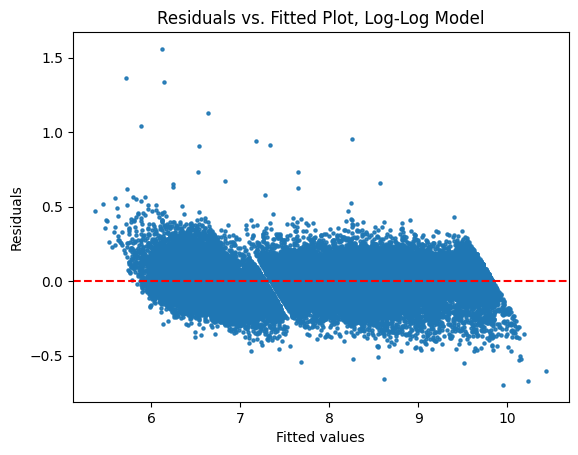

In [174]:
plt.scatter(loglog_mod.fittedvalues, loglog_mod.resid, s=5, alpha = 0.9)
plt.axhline(0, color = 'red', linestyle = 'dashed')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Plot, Log-Log Model")
plt.show()

In [175]:
# In the log transformed model, we see a better adjusted R squared value, and a huge improvement in AIC and BIC. We also have a pretty even residuals plot,
# with minimal curvature, and even spread. 

# We'll next back transform this model to get price predictions in actual full dollars, not log predictions.

In [176]:
sig2 = loglog_mod.resid.var()

dia_unique["predicted_log_price"] = loglog_mod.fittedvalues
dia_unique["predicted_price"] = np.exp(dia_unique["predicted_log_price"] + sig2 / 2)

In [177]:
r2 = r2_score(dia_unique["price"], dia_unique["predicted_price"])
mae = mean_absolute_error(dia_unique["price"], dia_unique["predicted_price"])

print(f"R-squared: {r2:.3f}, MAE: {mae:0.2f}")

relative_mae = mae / dia_unique["price"].mean()
print(f"Relative MAE: {relative_mae:.2%}")

R-squared: 0.970, MAE: 400.27
Relative MAE: 8.54%


In [180]:
X = dia_unique[["log_carat", "cut", "clarity", "color"]]
y = dia_unique["log_price"]

X = pd.get_dummies(X, drop_first = True)
model = LinearRegression()

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(model, X, y,
                         scoring = make_scorer(mean_absolute_percentage_error),
                         cv = cv)

print("Cross-validated MAPE:", np.mean(scores))

Cross-validated MAPE: 0.013086939460605063


In [ ]:
# From my relative MAE score and the cross-validation I've shown above with a MAPE score of 0.013, I do not find it necessary to continue modeling,
# as this model is only off by about 1.3% from the true pricing of the diamonds in this data set. I will concede that in the past few years, diamond pricing has changed 
# dramatically with the normalization of lab-grown diamonds, so this model may not accurately fit to a newer dataset, but for the diamond dataset availible, 
# this model shows great accuracy. 

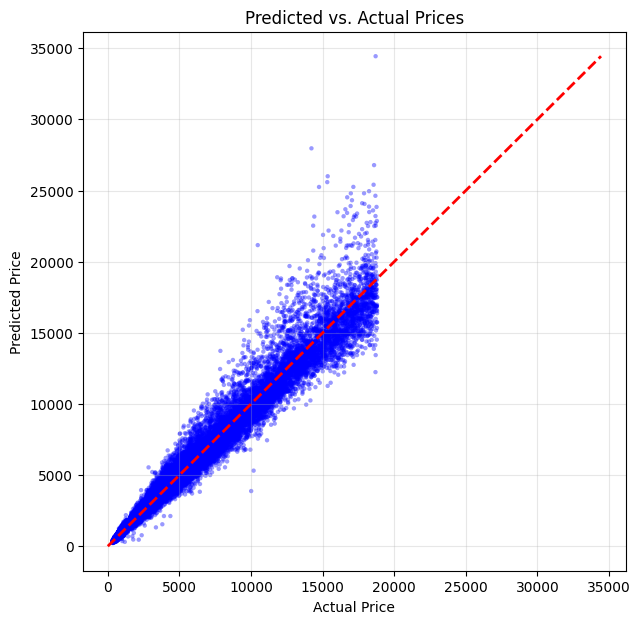

In [ ]:
plt.figure(figsize = (7,7))
plt.scatter(
    dia_unique["price"],
    dia_unique["predicted_price"],
    alpha = 0.4, s = 10, color = "blue", edgecolors = "none"
)

lims = [0, dia_unique[["price", "predicted_price"]].values.max()]
plt.plot(lims, lims, "r--", lw = 2)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices")
plt.grid(alpha=0.3)
plt.show()